In [39]:
!pip install joblib


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [40]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightgbm as lgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [10]:
df = pd.read_parquet("dielong.parquet")
df["thread"] = df["thread"].astype("int")

df_threads = df.groupby("thread")["fetched_at"].agg(["min", "max"]).reset_index()
df_threads.rename(columns={"min": "first", "max": "last"}, inplace=True)
df_threads["lifespan"] = df_threads["last"] - df_threads["first"]

df = df.merge(df_threads, on="thread")

# ときどき1970とかの古い日付が帰ってきているので、それを除く(手動でのスレッド削除かも？)
threads_too_far = df.groupby("thread")["dielong"].apply(lambda x: (x <= "2025-01-01").any())
df = df[~df["thread"].isin(threads_too_far[threads_too_far].index)].copy()

# スレッドが立ってからの相対的な経過分
df["relative_position"] = df.groupby("thread").cumcount()
df["relative_position_reverse"] = df.groupby("thread").transform("count")["dielong"] - df.groupby("thread").cumcount() - 1
df["relative_minute"] = df["relative_position"] * 10

# 本当のスレッド落ち時間と、データ取得時のスレッド落ちの予測時間との差を計算する
df["prediction_error"] = (df["dielong"] - df["last"]).dt.total_seconds() / 3600  # 時間へ変換

display(len(df["thread"].unique()))
display(df)

32977

,thread,fetched_at,dielong,first,last,lifespan,relative_position,relative_position_reverse,relative_minute,prediction_error
0,1286728284,2025-01-09 09:20:00,2025-01-09 21:01:06,2025-01-09 09:20:00,2025-01-09 17:00:00,0 days 07:40:00,0,46,0,4.018333
1,1286728284,2025-01-09 09:30:00,2025-01-09 21:08:21,2025-01-09 09:20:00,2025-01-09 17:00:00,0 days 07:40:00,1,45,10,4.139167
2,1286728284,2025-01-09 09:40:00,2025-01-09 21:15:24,2025-01-09 09:20:00,2025-01-09 17:00:00,0 days 07:40:00,2,44,20,4.256667
3,1286728284,2025-01-09 09:50:00,2025-01-09 21:22:18,2025-01-09 09:20:00,2025-01-09 17:00:00,0 days 07:40:00,3,43,30,4.371667
4,1286728284,2025-01-09 10:00:00,2025-01-09 21:29:02,2025-01-09 09:20:00,2025-01-09 17:00:00,0 days 07:40:00,4,42,40,4.483889
...,...,...,...,...,...,...,...,...,...,...
1607546,1301636177,2025-03-08 17:50:00,2025-03-08 19:19:07,2025-03-08 12:50:00,2025-03-08 18:30:00,0 days 05:40:00,30,4,300,0.818611
1607547,1301636177,2025-03-08 18:00:00,2025-03-08 19:14:42,2025-03-08 12:50:00,2025-03-08 18:30:00,0 days 05:40:00,31,3,310,0.745000
1607548,1301636177,2025-03-08 18:10:00,2025-03-08 19:11:23,2025-03-08 12:50:00,2025-03-08 18:30:00,0 days 05:40:00,32,2,320,0.689722
1607549,1301636177,2025-03-08 18:20:00,2025-03-08 19:07:51,2025-03-08 12:50:00,2025-03-08 18:30:00,0 days 05:40:00,33,1,330,0.630833


In [22]:
df_catalog = pd.read_parquet("catalog.parquet")
df_catalog

,fetched_at,catalog_length
0,2025-01-09 09:20:00,648
1,2025-01-09 09:30:00,654
2,2025-01-09 09:40:00,649
3,2025-01-09 09:50:00,650
4,2025-01-09 10:00:00,648
...,...,...
8411,2025-03-08 19:20:00,690
8412,2025-03-08 19:30:00,692
8413,2025-03-08 19:40:00,706
8414,2025-03-08 19:50:00,714


In [23]:
min_idx = df.groupby("thread")["fetched_at"].idxmin()
df_train = df.loc[min_idx].reset_index(drop=True).copy()
df_train = df_train.drop_duplicates(subset=["fetched_at"])
df_train = df_train.merge(df_catalog, on="fetched_at")

df_train

,thread,fetched_at,dielong,first,last,lifespan,relative_position,relative_position_reverse,relative_minute,prediction_error,hour,minute,weekday,target,catalog_length
0,1286728284,2025-01-09 09:20:00,2025-01-09 21:01:06,2025-01-09 09:20:00,2025-01-09 17:00:00,0 days 07:40:00,0,46,0,4.018333,9,20,3,460.0,648
1,1286728716,2025-01-09 09:30:00,2025-01-09 21:12:50,2025-01-09 09:30:00,2025-01-09 17:00:00,0 days 07:30:00,0,45,0,4.213889,9,30,3,450.0,654
2,1286729463,2025-01-09 09:40:00,2025-01-09 21:28:23,2025-01-09 09:40:00,2025-01-09 17:10:00,0 days 07:30:00,0,45,0,4.306389,9,40,3,450.0,649
3,1286731223,2025-01-09 09:50:00,2025-01-09 21:52:52,2025-01-09 09:50:00,2025-01-09 17:20:00,0 days 07:30:00,0,45,0,4.547778,9,50,3,450.0,650
4,1286731801,2025-01-09 10:00:00,2025-01-09 22:05:18,2025-01-09 10:00:00,2025-01-09 17:20:00,0 days 07:20:00,0,44,0,4.755000,10,0,3,440.0,648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7557,1301625784,2025-03-08 12:00:00,2025-03-09 00:27:47,2025-03-08 12:00:00,2025-03-08 17:50:00,0 days 05:50:00,0,35,0,6.629722,12,0,5,350.0,766
7558,1301627865,2025-03-08 12:10:00,2025-03-09 00:40:27,2025-03-08 12:10:00,2025-03-08 18:00:00,0 days 05:50:00,0,35,0,6.674167,12,10,5,350.0,775
7559,1301631779,2025-03-08 12:30:00,2025-03-09 01:03:59,2025-03-08 12:30:00,2025-03-08 18:10:00,0 days 05:40:00,0,34,0,6.899722,12,30,5,340.0,794
7560,1301633438,2025-03-08 12:40:00,2025-03-09 01:11:36,2025-03-08 12:40:00,2025-03-08 18:20:00,0 days 05:40:00,0,34,0,6.860000,12,40,5,340.0,800


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 6049, number of used features: 4
[LightGBM] [Info] Start training from score 230.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 6049, number of used features: 4
[LightGBM] [Info] Start training from score 410.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 6

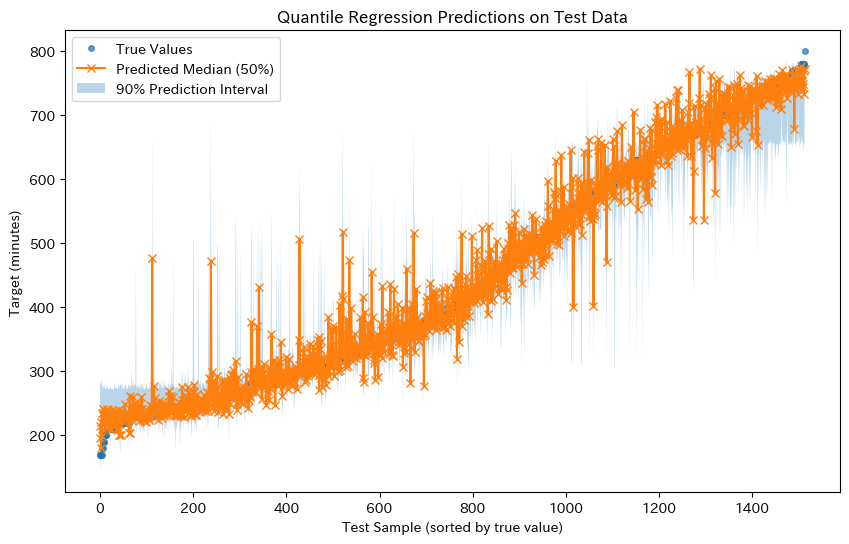

In [29]:

# fetched_atとlastの列をdatetime型に変換
df_train['fetched_at'] = pd.to_datetime(df_train['fetched_at'])
df_train['last'] = pd.to_datetime(df_train['last'])

# 説明変数として、fetched_atから時刻（hour, minute）と曜日（dayofweek）を抽出
df_train['hour'] = df_train['fetched_at'].dt.hour
df_train['minute'] = df_train['fetched_at'].dt.minute
df_train['weekday'] = df_train['fetched_at'].dt.dayofweek  # 月曜日=0, 日曜日=6

# 目的変数として、fetched_atからlastまでの時間差（分）を計算
df_train['target'] = (df_train['last'] - df_train['fetched_at']).dt.total_seconds() / 60

# 説明変数と目的変数を定義
features = ['hour', 'minute', 'weekday', 'catalog_length']
X = df_train[features]
y = df_train['target']

# 学習データとテストデータに分割（80%学習、20%テスト）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 分位点（quantile）の設定：下側5%、中央値50%、上側95%
quantiles = [0.05, 0.5, 0.95]
models = {}
predictions = {}

# 各分位点に対してLightGBMの回帰モデルを学習
for q in quantiles:
    model = lgb.LGBMRegressor(objective='quantile', alpha=q, random_state=42)
    model.fit(X_train, y_train)
    models[q] = model
    predictions[q] = model.predict(X_test)

# 中央値モデル（q=0.5）を用いて性能評価
y_pred_median = predictions[0.5]
mse = mean_squared_error(y_test, y_pred_median)
mae = mean_absolute_error(y_test, y_pred_median)
print("Median Model - Mean Squared Error:", mse)
print("Median Model - Mean Absolute Error:", mae)

# テストデータにおける予測区間の可視化
# ・x軸はテストサンプル（並び順は真の値の昇順に並べ替えています）
# ・中央値の予測と、下側・上側の予測による90%予測区間を表示
idx = np.argsort(y_test.values)  # y_testを昇順に並び替えるためのインデックス

plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(y_test)), y_test.values[idx], 
         'o', markersize=4, alpha=0.7, label='True Values')
plt.plot(np.arange(len(y_test)), predictions[0.5][idx], 
         'x-', label='Predicted Median (50%)')
plt.fill_between(np.arange(len(y_test)),
                 predictions[0.05][idx],
                 predictions[0.95][idx],
                 alpha=0.3, label='90% Prediction Interval')
plt.xlabel("Test Sample (sorted by true value)")
plt.ylabel("Target (minutes)")
plt.title("Quantile Regression Predictions on Test Data")
plt.legend()
plt.show()


In [38]:
# 学習済みモデル: model
# 特定の時刻・曜日を指定
hour = 20
minute = 30
weekday = 2
catalog_length = 400,

# 予測用DataFrameを作成（1行のみ）
X_sample = pd.DataFrame({
    'hour': [hour],
    'minute': [minute],
    'weekday': [weekday],
    'catalog_length': catalog_length,
})

# 下側5%・中央値50%・上側95% それぞれの予測値を取得
y_lower = models[0.05].predict(X_sample)
y_median = models[0.5].predict(X_sample)
y_upper = models[0.95].predict(X_sample)

# 結果を出力（配列として返るので[0]で値を取り出す）
print(f"【{hour}時{minute}分 / weekday={weekday}】")
print(f"下側5%予測 : {y_lower[0]:.2f}")
print(f"中央値   : {y_median[0]:.2f}")
print(f"上側95%予測: {y_upper[0]:.2f}")
print(f"予測レンジ: {y_lower[0]:.2f} ~ {y_upper[0]:.2f} （中央値: {y_median[0]:.2f}）")

【20時30分 / weekday=2】
下側5%予測 : 169.62
中央値   : 202.94
上側95%予測: 283.66
予測レンジ: 169.62 ~ 283.66 （中央値: 202.94）


In [41]:
for q in quantiles:
    # quantile 毎に別ファイルへ保存（例："lgbm_quantile_5.pkl", "lgbm_quantile_50.pkl", "lgbm_quantile_95.pkl"）
    file_name = f"lgbm_quantile_{int(q*100)}.pkl"
    joblib.dump(model, file_name)
    print(f"Model for quantile {q} saved to {file_name}")

Model for quantile 0.05 saved to lgbm_quantile_5.pkl
Model for quantile 0.5 saved to lgbm_quantile_50.pkl
Model for quantile 0.95 saved to lgbm_quantile_95.pkl
